In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

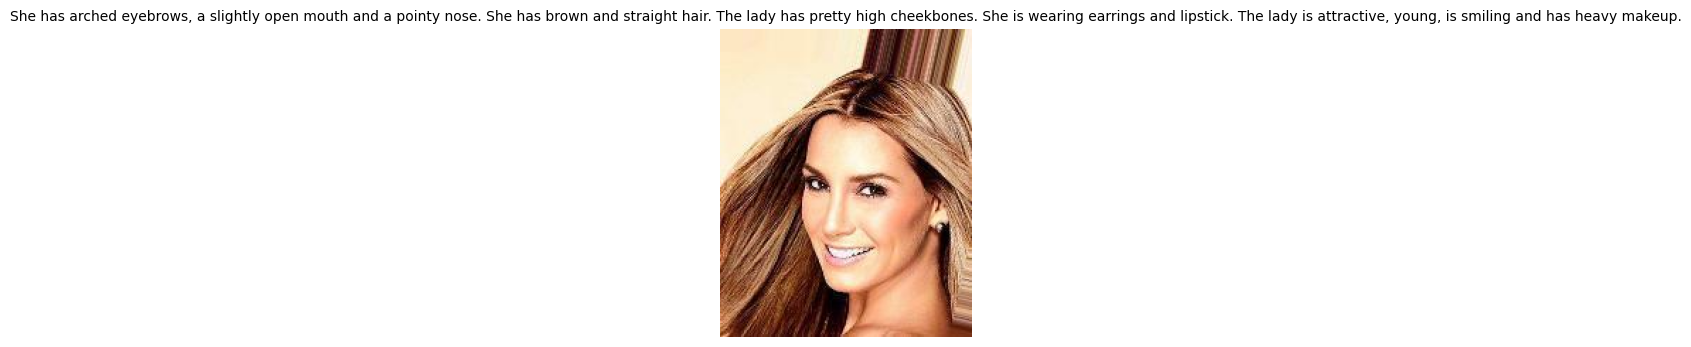

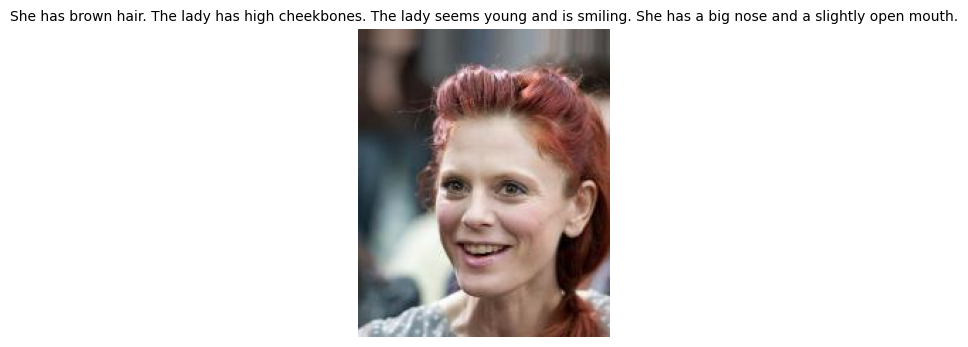

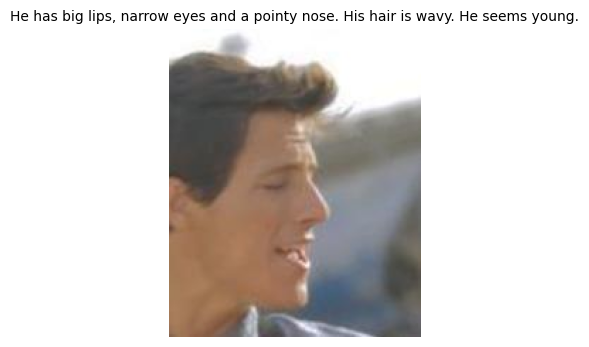

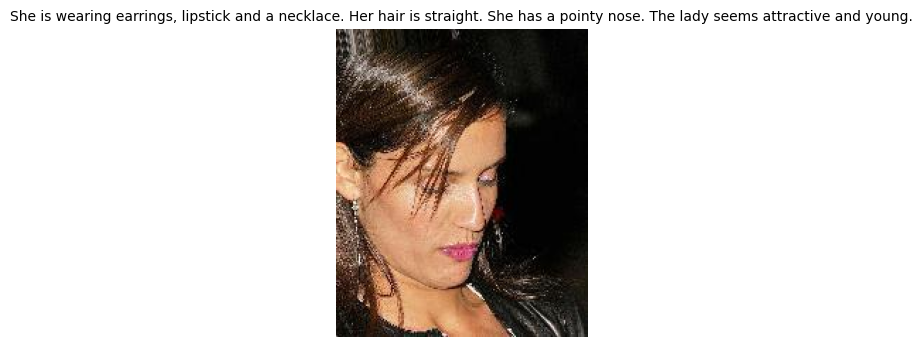

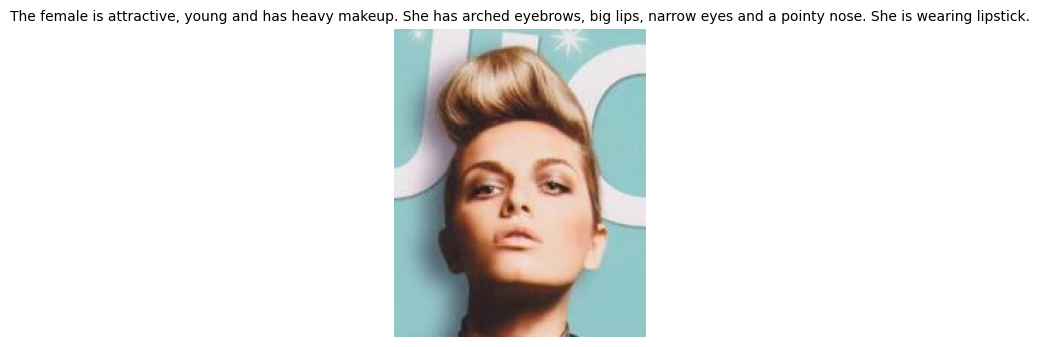

In [30]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# === Paths ===
csv_file_path = "text_shuffle_descr_celeba.csv"  # Replace with your CSV file path
image_folder_path = "img_align_celeba"          # Replace with your image folder path

# === Load Data ===
# Load the CSV file
data = pd.read_csv(csv_file_path).iloc[:5]  # Load only 5 rows for demonstration

# Define the image transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# === Display Images with Text ===
for idx, row in data.iterrows():
    image_id = row["image_id"]
    text_description = row["text_description"]
    
    # Load the image
    image_path = os.path.join(image_folder_path, image_id)
    image = Image.open(image_path).convert("RGB")
    
    # Plot the image and text
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(text_description, fontsize=10)
    plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# === Configure Device ===
device = torch.device("cpu")  # Use "cpu" since CUDA is not enabled

# === Dataset Class ===
class ImageTextDataset(Dataset):
    def __init__(self, csv_data, image_folder, transform=None):
        self.csv_data = csv_data
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        image_filename = self.csv_data.iloc[idx]["image_id"]
        image_path = os.path.join(self.image_folder, image_filename)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        text_description = self.csv_data.iloc[idx]["text_description"]
        return image, text_description

# === Image Transformations ===
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# === Load Data (Subset of 2000 Rows) ===
csv_file_path = "text_shuffle_descr_celeba.csv"  # Update with your file path
image_folder_path = "img_align_celeba"          # Update with your folder path
text_descriptions_df = pd.read_csv(csv_file_path).iloc[:2000]  # Use only the first 2000 rows
dataset = ImageTextDataset(text_descriptions_df, image_folder_path, transform=image_transforms)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# === Text Embedding Model ===
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_model = AutoModel.from_pretrained("distilbert-base-uncased")
text_model.eval()

# === Generator ===
class Generator(nn.Module):
    def __init__(self, noise_dim, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(embedding_size, reduced_dim_size),
            nn.BatchNorm1d(reduced_dim_size),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + reduced_dim_size, feature_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        text_embedding = self.projection(text_embedding)
        combined = torch.cat([noise, text_embedding], dim=1).unsqueeze(2).unsqueeze(3)
        return self.layers(combined)

generator = Generator(noise_dim=100, feature_size=64, num_channels=3, embedding_size=768, reduced_dim_size=256).to(device)

# === Discriminator ===
class Discriminator(nn.Module):
    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.image_branch = nn.Sequential(
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.text_branch = nn.Sequential(
            nn.Linear(embedding_size, reduced_dim_size),
            nn.BatchNorm1d(reduced_dim_size),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.final = nn.Sequential(
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.AdaptiveAvgPool2d((1, 1)),  # Ensure output spatial dimensions are 1x1
            nn.Flatten(),  # Flatten to shape [batch_size, 1]
            nn.Sigmoid()  # Ensure output values are in [0, 1]
        )

    def forward(self, image, text_embedding):
        image_features = self.image_branch(image)
        text_features = self.text_branch(text_embedding).unsqueeze(2).unsqueeze(3)
        text_features = text_features.expand(-1, -1, image_features.size(2), image_features.size(3))
        combined = torch.cat([image_features, text_features], dim=1)
        validity = self.final(combined)
        return validity

discriminator = Discriminator(num_channels=3, feature_size=64, embedding_size=768, reduced_dim_size=256).to(device)

# === Training Configuration ===
num_epochs = 15
learning_rate = 0.0002
criterion = nn.BCELoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# === Training Loop ===
for epoch in range(num_epochs):
    for i, (real_images, text_descriptions) in enumerate(dataloader):
        batch_size = real_images.size(0)
        text_embeddings = []

        for desc in text_descriptions:
            inputs = tokenizer(desc, return_tensors="pt", truncation=True, padding=True)
            with torch.no_grad():
                outputs = text_model(**inputs)
                text_embeddings.append(outputs.last_hidden_state.mean(dim=1))
        text_embeddings = torch.cat(text_embeddings).to(device)

        real_images = real_images.to(device)
        noise = torch.randn(batch_size, 100).to(device)

        # Train Discriminator
        discriminator.zero_grad()
        fake_images = generator(noise, text_embeddings)
        real_labels = torch.full((batch_size, 1), 0.9, device=device)
        fake_labels = torch.full((batch_size, 1), 0.1, device=device)
        real_output = discriminator(real_images, text_embeddings)
        fake_output = discriminator(fake_images.detach(), text_embeddings)
        lossD_real = criterion(real_output, real_labels)
        lossD_fake = criterion(fake_output, fake_labels)
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # Train Generator
        generator.zero_grad()
        fake_output = discriminator(fake_images, text_embeddings)
        lossG = criterion(fake_output, real_labels)
        lossG.backward()
        optimizerG.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                  f"Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")


c:\Users\Riddhi Sharama\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/15], Step [0/16], Loss D: 1.3443, Loss G: 3.9767
Epoch [1/15], Step [10/16], Loss D: 0.8649, Loss G: 6.1449
Epoch [2/15], Step [0/16], Loss D: 0.9052, Loss G: 5.7447
Epoch [2/15], Step [10/16], Loss D: 0.8038, Loss G: 3.1658
Epoch [3/15], Step [0/16], Loss D: 0.7789, Loss G: 3.1318
Epoch [3/15], Step [10/16], Loss D: 0.6744, Loss G: 2.7600
Epoch [4/15], Step [0/16], Loss D: 0.6776, Loss G: 3.1200
Epoch [4/15], Step [10/16], Loss D: 0.7011, Loss G: 2.4105
Epoch [5/15], Step [0/16], Loss D: 0.6649, Loss G: 2.2331
Epoch [5/15], Step [10/16], Loss D: 0.6615, Loss G: 2.4079
Epoch [6/15], Step [0/16], Loss D: 0.6722, Loss G: 3.0569
Epoch [6/15], Step [10/16], Loss D: 0.6759, Loss G: 2.2137
Epoch [7/15], Step [0/16], Loss D: 0.6886, Loss G: 2.1271
Epoch [7/15], Step [10/16], Loss D: 0.6816, Loss G: 2.1133
Epoch [8/15], Step [0/16], Loss D: 0.6581, Loss G: 2.2573
Epoch [8/15], Step [10/16], Loss D: 0.6605, Loss G: 2.2096
Epoch [9/15], Step [0/16], Loss D: 0.6586, Loss G: 2.5254
Epoch 

In [25]:
# Save model function
def save_model(model, model_name):
    save_path = f"{model_name}_15_epochs.pth"
    torch.save(model.state_dict(), save_path)
    print(f"{model_name} saved at {save_path}")

# Call the save function after training
save_model(generator, "generator")
save_model(discriminator, "discriminator")


generator saved at generator_15_epochs.pth
discriminator saved at discriminator_15_epochs.pth


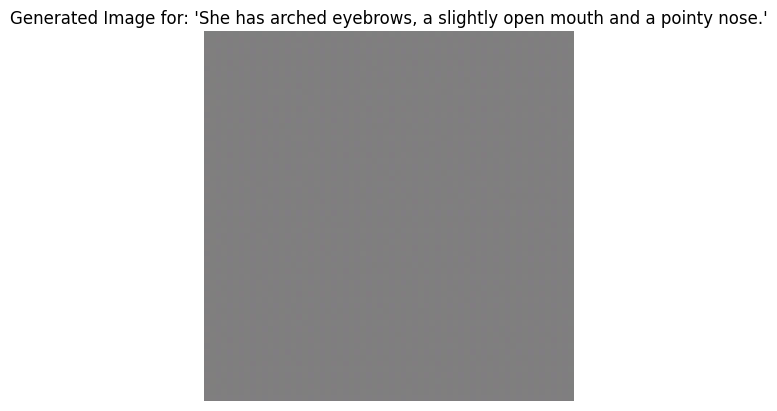

In [32]:
import matplotlib.pyplot as plt

# Function to generate an image from a text input
def generate_image_from_text(generator, text_input, tokenizer, text_model, device):
    # Generate text embedding
    inputs = tokenizer(text_input, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
        text_embedding = outputs.last_hidden_state.mean(dim=1).to(device)

    # Generate random noise
    noise = torch.randn(1, 100).to(device)

    # Generate image
    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        generated_image = generator(noise, text_embedding).squeeze(0).permute(1, 2, 0).cpu().numpy()
        generated_image = (generated_image + 1) / 2.0  # Normalize to [0, 1] for visualization
    return generated_image

# Example text input
text_input = "She has arched eyebrows, a slightly open mouth and a pointy nose."  # Replace with relevant description from your dataset

# Generate image
generated_image = generate_image_from_text(generator, text_input, tokenizer, text_model, device)

# Visualize the generated image
plt.imshow(generated_image)
plt.axis("off")
plt.title(f"Generated Image for: '{text_input}'")
plt.show()


In [8]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import AutoTokenizer

class TextToFaceDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None, tokenizer=None):
        self.data = pd.read_csv(csv_file)  # Load CSV file with image paths and descriptions
        self.image_folder = image_folder  # Path to CelebA images
        self.transform = transform  # Image transformations
        self.tokenizer = tokenizer  # Text tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_folder, self.data.iloc[idx]["image_id"])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize text description
        text = self.data.iloc[idx]["text_description"]
        tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        return image, tokens


c:\Users\Riddhi Sharama\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoTokenizer

# File paths (update these to match your setup)
csv_file = "text_shuffle_descr_celeba.csv"  # Path to your CSV file
image_folder = "img_align_celeba"  # Path to CelebA images folder

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define image transformations
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Create dataset
dataset = TextToFaceDataset(csv_file, image_folder, transform=image_transforms, tokenizer=tokenizer)

# Create dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [12]:
class TextToFaceDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None, tokenizer=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_folder, self.data.iloc[idx]["image_id"])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize text with padding and truncation
        text = self.data.iloc[idx]["text_description"]
        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",  # Pad to a fixed length
            truncation=True,
            max_length=50  # Adjust max length as needed
        )

        return image, tokens


In [16]:
print(f"Noise shape: {noise.shape}")
print(f"Text embedding shape: {text_embeddings.shape}")
print(f"Fake image shape: {fake_images.shape}")
print(f"Real image shape: {images.shape}")


Noise shape: torch.Size([32, 100])
Text embedding shape: torch.Size([32, 768])
Fake image shape: torch.Size([32, 3, 32, 32])
Real image shape: torch.Size([32, 3, 128, 128])


In [26]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoTokenizer, AutoModel

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Dataset Class ===
class TextToFaceDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None, tokenizer=None, max_length=50):
        self.data = pd.read_csv(csv_file).iloc[:2000]  # Use only the first 2000 samples
        self.image_folder = image_folder
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_folder, self.data.iloc[idx]["image_id"])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize text with padding and truncation
        text = self.data.iloc[idx]["text_description"]
        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )

        return image, tokens

# === Hyperparameters ===
batch_size = 32
noise_dim = 100
text_embedding_dim = 768  # From BERT
image_channels = 3
feature_size = 64
lr_generator = 0.0002
lr_discriminator = 0.00005  # Lower learning rate for the discriminator
num_epochs = 50  # Increased epochs for better training
max_length = 50  # Maximum token length for text descriptions

# === File Paths ===
csv_file = "text_shuffle_descr_celeba.csv"  # Update with your CSV file
image_folder = "img_align_celeba"  # Update with your image folder path

# === Tokenizer and Transformations ===
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# === Dataset and DataLoader ===
dataset = TextToFaceDataset(
    csv_file=csv_file,
    image_folder=image_folder,
    transform=image_transforms,
    tokenizer=tokenizer,
    max_length=max_length
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# === Conditional Batch Normalization (CBN) ===
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, text_embedding_dim):
        super(ConditionalBatchNorm2d, self).__init__()
        self.bn = nn.BatchNorm2d(num_features)
        self.fc_gamma = nn.Linear(text_embedding_dim, num_features)
        self.fc_beta = nn.Linear(text_embedding_dim, num_features)

    def forward(self, x, text_embedding):
        gamma = self.fc_gamma(text_embedding).unsqueeze(2).unsqueeze(3)
        beta = self.fc_beta(text_embedding).unsqueeze(2).unsqueeze(3)
        return self.bn(x) * gamma + beta

# === Model Definitions ===
class Generator(nn.Module):
    def __init__(self, noise_dim, text_embedding_dim, feature_size, image_channels):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + text_embedding_dim, feature_size * 8 * 8 * 8),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1),  # (8 -> 16)
            nn.ReLU(),
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1),  # (16 -> 32)
            nn.ReLU(),
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1),  # (32 -> 64)
            nn.ReLU(),
            nn.ConvTranspose2d(feature_size, image_channels, 4, 2, 1),  # (64 -> 128)
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        x = torch.cat((noise, text_embedding), dim=1)  # [batch_size, noise_dim + text_embedding_dim]
        x = self.fc(x)  # Fully connected layer
        x = x.view(x.size(0), -1, 8, 8)  # Reshape into [batch_size, channels, height, width]
        return self.deconv(x)

class Discriminator(nn.Module):
    def __init__(self, image_channels, text_embedding_dim, feature_size):
        super(Discriminator, self).__init__()
        self.image_branch = nn.Sequential(
            nn.Conv2d(image_channels, feature_size, 4, 2, 1),  # (128 -> 64)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Regularization
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1),  # (64 -> 32)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1),  # (32 -> 16)
            nn.LeakyReLU(0.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(feature_size * 4 * 16 * 16 + text_embedding_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, image, text_embedding):
        noise = torch.randn_like(image) * 0.05  # Add Gaussian noise
        image = image + noise
        image_features = self.image_branch(image).view(image.size(0), -1)
        x = torch.cat((image_features, text_embedding), dim=1)  # [batch_size, concatenated_dim]
        return self.fc(x)

# === Initialize Models ===
generator = Generator(noise_dim, text_embedding_dim, feature_size, image_channels).to(device)
discriminator = Discriminator(image_channels, text_embedding_dim, feature_size).to(device)

# === Loss and Optimizers ===
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr_generator)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_discriminator)

# === Load Pre-trained Text Model ===
text_model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
text_model.eval()  # Set text model to evaluation mode

# === Training Loop ===
for epoch in range(num_epochs):
    for i, (images, tokenized_text) in enumerate(dataloader):
        # Move data to device
        images = images.to(device)
        input_ids = tokenized_text["input_ids"].squeeze(1).to(device)
        attention_mask = tokenized_text["attention_mask"].squeeze(1).to(device)

        # Extract text embeddings
        with torch.no_grad():
            text_embeddings = text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.mean(dim=1)

        # Generate noise
        noise = torch.randn(images.size(0), noise_dim).to(device)

        # === Train Discriminator ===
        fake_images = generator(noise, text_embeddings)  # [batch_size, 3, 128, 128]

        # Apply label smoothing
        real_labels = torch.full((images.size(0), 1), 0.9).to(device)  # Smooth real labels to 0.9
        fake_labels = torch.full((images.size(0), 1), 0.1).to(device)  # Smooth fake labels to 0.1

        discriminator.zero_grad()
        real_loss = criterion(discriminator(images, text_embeddings), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach(), text_embeddings), fake_labels)
        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer_d.step()

        # === Train Generator ===
        if i % 2 == 0:  # Train generator every 2 steps
            generator.zero_grad()
            fake_loss = criterion(discriminator(fake_images, text_embeddings), real_labels)  # Flip labels for generator
            fake_loss.backward()
            optimizer_g.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                  f"Loss D: {loss_d.item():.4f}, Loss G: {fake_loss.item():.4f}")


Epoch [1/50], Step [0/63], Loss D: 1.3805, Loss G: 0.6828
Epoch [1/50], Step [10/63], Loss D: 1.0717, Loss G: 0.7048
Epoch [1/50], Step [20/63], Loss D: 0.8889, Loss G: 1.1000
Epoch [1/50], Step [30/63], Loss D: 0.7101, Loss G: 1.8450
Epoch [1/50], Step [40/63], Loss D: 0.7358, Loss G: 3.1662
Epoch [1/50], Step [50/63], Loss D: 0.7577, Loss G: 2.9351
Epoch [1/50], Step [60/63], Loss D: 0.7163, Loss G: 2.7459
Epoch [2/50], Step [0/63], Loss D: 0.7468, Loss G: 1.7261
Epoch [2/50], Step [10/63], Loss D: 0.6986, Loss G: 1.8681
Epoch [2/50], Step [20/63], Loss D: 0.6758, Loss G: 2.1773
Epoch [2/50], Step [30/63], Loss D: 0.6793, Loss G: 2.3867
Epoch [2/50], Step [40/63], Loss D: 0.6705, Loss G: 2.4120
Epoch [2/50], Step [50/63], Loss D: 0.6808, Loss G: 2.2679
Epoch [2/50], Step [60/63], Loss D: 0.6621, Loss G: 2.2355
Epoch [3/50], Step [0/63], Loss D: 0.6856, Loss G: 1.7664
Epoch [3/50], Step [10/63], Loss D: 0.6816, Loss G: 1.8457
Epoch [3/50], Step [20/63], Loss D: 0.6710, Loss G: 2.3530


In [28]:
# Save the Generator and Discriminator
torch.save(generator.state_dict(), "generator_final.pth")
torch.save(discriminator.state_dict(), "discriminator_final.pth")
print("Generator and Discriminator models saved as 'generator_final.pth' and 'discriminator_final.pth'")


Generator and Discriminator models saved as 'generator_final.pth' and 'discriminator_final.pth'


In [7]:


# Load the trained generator model
generator = Generator(noise_dim, text_embedding_dim, feature_size, image_channels).to(device)
generator.load_state_dict(torch.load("generator_final.pth", map_location=device))
generator.eval()  # Set to evaluation mode

# Load the pre-trained text embedding model
text_model.eval()
print("Generator and Text Model loaded successfully.")


C:\Users\Riddhi Sharama\AppData\Local\Temp\ipykernel_11856\1972894518.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_fin

RuntimeError: Error(s) in loading state_dict for Generator:
	size mismatch for fc.0.weight: copying a param with shape torch.Size([32768, 868]) from checkpoint, the shape in current model is torch.Size([131072, 868]).
	size mismatch for fc.0.bias: copying a param with shape torch.Size([32768]) from checkpoint, the shape in current model is torch.Size([131072]).

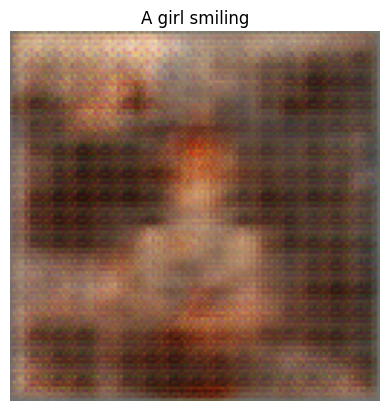

In [30]:
import matplotlib.pyplot as plt

# Text description for testing
test_description = "A girl smiling"

# Generate random noise
noise = torch.randn(1, noise_dim).to(device)  # Single noise vector for testing

# Tokenize and generate the text embedding
inputs = tokenizer(test_description, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length).to(device)
with torch.no_grad():
    text_embedding = text_model(**inputs).last_hidden_state.mean(dim=1)  # Text embedding

# Generate the image using the Generator
with torch.no_grad():
    fake_image = generator(noise, text_embedding).detach().cpu()  # Generated image

# Visualize the generated image
plt.imshow((fake_image[0].permute(1, 2, 0) + 1) / 2.0)  # Normalize to [0, 1] for display
plt.axis("off")
plt.title(test_description)
plt.show()


In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoTokenizer, AutoModel

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Dataset Class ===
class TextToFaceDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None, tokenizer=None, max_length=50):
        self.data = pd.read_csv(csv_file).iloc[:4000]  # Use the first 4000 samples
        self.image_folder = image_folder
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_folder, self.data.iloc[idx]["image_id"])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize text with padding and truncation
        text = self.data.iloc[idx]["text_description"]
        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )

        return image, tokens

# === Hyperparameters ===
batch_size = 32
noise_dim = 100
text_embedding_dim = 768  # From BERT
image_channels = 3
feature_size = 64
lr_generator = 0.0002
lr_discriminator = 0.00005  # Lower learning rate for the discriminator
num_epochs = 30  # Adjusted epochs for training
max_length = 50  # Maximum token length for text descriptions

# === File Paths ===
csv_file = "text_shuffle_descr_celeba.csv"  # Update with your CSV file
image_folder = "img_align_celeba"  # Update with your image folder path

# === Tokenizer and Transformations ===
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Increased resolution to 256x256
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# === Dataset and DataLoader ===
dataset = TextToFaceDataset(
    csv_file=csv_file,
    image_folder=image_folder,
    transform=image_transforms,
    tokenizer=tokenizer,
    max_length=max_length
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# === Conditional Batch Normalization (CBN) ===
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, text_embedding_dim):
        super(ConditionalBatchNorm2d, self).__init__()
        self.bn = nn.BatchNorm2d(num_features)
        self.fc_gamma = nn.Linear(text_embedding_dim, num_features)
        self.fc_beta = nn.Linear(text_embedding_dim, num_features)

    def forward(self, x, text_embedding):
        gamma = self.fc_gamma(text_embedding).unsqueeze(2).unsqueeze(3)
        beta = self.fc_beta(text_embedding).unsqueeze(2).unsqueeze(3)
        return self.bn(x) * gamma + beta

# === Model Definitions ===
class Generator(nn.Module):
    def __init__(self, noise_dim, text_embedding_dim, feature_size, image_channels):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + text_embedding_dim, feature_size * 16 * 16 * 8),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1),  # (16 -> 32)
            nn.ReLU(),
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1),  # (32 -> 64)
            nn.ReLU(),
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1),  # (64 -> 128)
            nn.ReLU(),
            nn.ConvTranspose2d(feature_size, image_channels, 4, 2, 1),  # (128 -> 256)
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        x = torch.cat((noise, text_embedding), dim=1)  # [batch_size, noise_dim + text_embedding_dim]
        x = self.fc(x)  # Fully connected layer
        x = x.view(x.size(0), -1, 16, 16)  # Reshape into [batch_size, channels, height, width]
        return self.deconv(x)

class Discriminator(nn.Module):
    def __init__(self, image_channels, text_embedding_dim, feature_size):
        super(Discriminator, self).__init__()
        self.image_branch = nn.Sequential(
            nn.Conv2d(image_channels, feature_size, 4, 2, 1),  # (256 -> 128)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Regularization
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1),  # (128 -> 64)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1),  # (64 -> 32)
            nn.LeakyReLU(0.2),
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1),  # (32 -> 16)
            nn.LeakyReLU(0.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(feature_size * 8 * 16 * 16 + text_embedding_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, image, text_embedding):
        noise = torch.randn_like(image) * 0.05  # Add Gaussian noise
        image = image + noise
        image_features = self.image_branch(image).view(image.size(0), -1)
        x = torch.cat((image_features, text_embedding), dim=1)  # [batch_size, concatenated_dim]
        return self.fc(x)

# === Initialize Models ===
generator = Generator(noise_dim, text_embedding_dim, feature_size, image_channels).to(device)
discriminator = Discriminator(image_channels, text_embedding_dim, feature_size).to(device)

# === Loss and Optimizers ===
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr_generator)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_discriminator)

# === Load Pre-trained Text Model ===
text_model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
text_model.eval()  # Set text model to evaluation mode

# === Training Loop ===
for epoch in range(num_epochs):
    for i, (images, tokenized_text) in enumerate(dataloader):
        # Move data to device
        images = images.to(device)
        input_ids = tokenized_text["input_ids"].squeeze(1).to(device)
        attention_mask = tokenized_text["attention_mask"].squeeze(1).to(device)

        # Extract text embeddings
        with torch.no_grad():
            text_embeddings = text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.mean(dim=1)

        # Generate noise
        noise = torch.randn(images.size(0), noise_dim).to(device)

        # === Train Discriminator ===
        fake_images = generator(noise, text_embeddings)  # [batch_size, 3, 256, 256]

        # Apply label smoothing
        real_labels = torch.full((images.size(0), 1), 0.9).to(device)  # Smooth real labels to 0.9
        fake_labels = torch.full((images.size(0), 1), 0.1).to(device)  # Smooth fake labels to 0.1

        discriminator.zero_grad()
        real_loss = criterion(discriminator(images, text_embeddings), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach(), text_embeddings), fake_labels)
        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer_d.step()

        # === Train Generator ===
        if i % 2 == 0:  # Train generator every 2 steps
            generator.zero_grad()
            fake_loss = criterion(discriminator(fake_images, text_embeddings), real_labels)  # Flip labels for generator
            fake_loss.backward()
            optimizer_g.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                  f"Loss D: {loss_d.item():.4f}, Loss G: {fake_loss.item():.4f}")




c:\Users\Riddhi Sharama\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/30], Step [0/125], Loss D: 1.3895, Loss G: 0.6765
Epoch [1/30], Step [10/125], Loss D: 1.0887, Loss G: 0.7153
Epoch [1/30], Step [20/125], Loss D: 0.7838, Loss G: 1.7535
Epoch [1/30], Step [30/125], Loss D: 0.7157, Loss G: 2.1438
Epoch [1/30], Step [40/125], Loss D: 0.7528, Loss G: 2.4678
Epoch [1/30], Step [50/125], Loss D: 0.7198, Loss G: 2.3647
Epoch [1/30], Step [60/125], Loss D: 0.6938, Loss G: 2.9654
Epoch [1/30], Step [70/125], Loss D: 0.6882, Loss G: 3.0468
Epoch [1/30], Step [80/125], Loss D: 0.6649, Loss G: 2.2366
Epoch [1/30], Step [90/125], Loss D: 0.6625, Loss G: 2.3755
Epoch [1/30], Step [100/125], Loss D: 0.6569, Loss G: 2.2337
Epoch [1/30], Step [110/125], Loss D: 0.6624, Loss G: 2.3387
Epoch [1/30], Step [120/125], Loss D: 0.6550, Loss G: 2.3179
Epoch [2/30], Step [0/125], Loss D: 0.6597, Loss G: 2.2909
Epoch [2/30], Step [10/125], Loss D: 0.6543, Loss G: 2.1943
Epoch [2/30], Step [20/125], Loss D: 0.6669, Loss G: 2.5036
Epoch [2/30], Step [30/125], Loss D: 0.

KeyboardInterrupt: 

In [6]:
torch.save(generator, "generatorentire.pth")
print("Generator (entire model) saved successfully.")

torch.save(generator.state_dict(), "generatorstate_dict.pth")
print("Generator (state dict) saved successfully.")

torch.save(discriminator, "discriminatorentire.pth")
print("Discriminator (entire model) saved successfully.")

torch.save(discriminator.state_dict(), "discriminatorstatedict.pth")
print("Discriminator (state dict) saved successfully.")

torch.save(text_model, "textmodelentire.pth")
print("Text embedding model saved successfully.")


Generator (entire model) saved successfully.
Generator (state dict) saved successfully.
Discriminator (entire model) saved successfully.
Discriminator (state dict) saved successfully.
Text embedding model saved successfully.
